In [1]:
import os
import pickle
from natsort import natsorted
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import oapackage as oa
from natsort import natsorted
#import Orange

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib
%matplotlib inline

# Model Selection
## integrate three selection strategies


In [20]:
# functions for DTO
def l2norm(matrix_1, matrix_2):
    """calculate Euclidean distance
    Args:
        matrix_1 (n*d np array): n is the number of instances, d is num of metric
        matrix_2 (n*d np array): same as matrix_1
    Returns:
        float: the row-wise Euclidean distance 
    """
    return np.power(np.sum(np.power(matrix_1-matrix_2, 2), axis=1), 0.5)
    

def DTO(performacne_metric):
    """calculate DTO for each condidate model
    Args:
        performacne_metric (array): 2D array, row: models, column: AUC of different subgroups
    """

    normalized_metric = np.zeros(performacne_metric.shape)
    utopias = []
    for i in range(performacne_metric.shape[1]):
        utopias.append(np.max(performacne_metric[:, i]))
        normalized_metric[:, i] = performacne_metric[:, i] / np.max(performacne_metric[:, i])
    
    # Calculate Euclidean distance
    distances = l2norm(normalized_metric, np.ones_like(normalized_metric))
    
    # return the index of model with the smallest distance
    return np.argmin(distances)

In [21]:
# Functions for Pareto

def find_mingroup(df):
    aucs = df[list(df.filter(regex=("auc-group")))]
    aucs = aucs.to_numpy()
    maxs = []
    for i in range(aucs.shape[1]):
        temp = aucs[:, i].tolist()
        maxs.append(max(temp))
    min_idx = np.argmin(maxs)
    return min_idx
    

def get_groups(df, metric = 'auc'):
    aucs = df[natsorted(list(df.filter(regex=(metric+'-group'))))].values.T
    groups = []
    for i in range((aucs.shape[0])):
        groups.append(aucs[i, :].astype('float'))
    return groups

def cal_pareto(groups, min_group_no):
    pareto=oa.ParetoDoubleLong()
    for i in range(groups[0].shape[0]):
        w= oa.doubleVector(tuple([group[i] for group in groups]))
        pareto.addvalue(w, i)
    datapoints = np.stack(groups)
    lst=pareto.allindices()
    optimal_datapoints=datapoints[:,lst]

    loc = np.argmax(optimal_datapoints.T[:, min_group_no])
    #loc = np.argmax(optimal_datapoints.T[:, 1])
    return lst[loc]


In [22]:
# config

# exp_dict = {'HAM10000': [{'attribute': 'Sex', 'sens_num': 2}], 'HAM100004': [{'attribute': 'Age', 'sens_num': 4}], 
#            'CXP': [{'attribute': 'Age', 'sens_num': 5}, {'attribute': 'Sex', 'sens_num': 2}, {'attribute': 'Race', 'sens_num': 2}],
#            'MIMIC_CXR': [{'attribute': 'Age', 'sens_num': 5}, {'attribute': 'Sex', 'sens_num': 2}, {'attribute': 'Race', 'sens_num': 2}],
#            'PAPILA': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
#            'ADNI': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
#            'OCT': [{'attribute': 'Age', 'sens_num': 2}],
#            'COVID_CT_MD': [{'attribute': 'Age', 'sens_num': 2}, {'attribute': 'Sex', 'sens_num': 2}],
#            'Fitz17k': [{'attribute': 'skin_type', 'sens_num': 6}],}

exp_dict = {'MIMIC_CXR':[{'attribute': 'Age', 'sens_num': 5},{'attribute':'Sex','sens_num':2},{'attribute':'Race','sens_num':2}]}

model_selections = ['overall_auc']
#, 'DTO']
#model_selections = ['overall_auc', 'pareto', 'DTO']

methods = ['baseline', 'resampling', 'LAFTR','GroupDRO', 'SWAD','DomainInd']
#methods = ['baseline', 'resampling', 'DomainInd', 'LAFTR', 'CFair','LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']

path = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/your_path/fariness_data/model_records/'

In [23]:
results = pd.DataFrame()

# should probably figure out a more sustainable way to write this code so that if some data is missing it still runs!!

for model_selection in model_selections:
    for key, sens_exps in exp_dict.items():
        dataset = key
        for sens_exp in sens_exps:
            methods = ['baseline', 'resampling', 'LAFTR','GroupDRO', 'SWAD','DomainInd']

            attribute = sens_exp['attribute']
            sens_num = sens_exp['sens_num']
            if dataset in ['OCT', 'ADNI', 'COVID_CT_MD']:
                backbone = 'cusResNet18_3d'
            elif dataset in ['RadFusion_EHR']:
                backbone = 'cusMLP'
            else:
                backbone = 'cusResNet18'
            
            means, stds, hashs = [], [], []
            #index = []
            mean_metrics = pd.DataFrame()
            std_metrics = pd.DataFrame()

            for method in methods:
                val_stats = natsorted(glob.glob(path + '/{datas}/{attr}/{bkb}/{meth}/*_val_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone, meth = method)))
                
                test_stats = natsorted(glob.glob(path + '/{datas}/{attr}/{bkb}/{meth}/*_test_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone, meth = method)))
                
                val_metrics = pd.DataFrame()
                
                for val_stat in val_stats:
                    hash_id = val_stat.split('/')[-1].split('_')[1]
                    val_stat_df = pd.read_csv(val_stat)
                    val_stat_df['hash'] = hash_id
                    val_metrics = pd.concat([val_metrics, pd.DataFrame(val_stat_df.iloc[0]).T], ignore_index=True)
                
                # decide min/max AUC group before selection
                if method == 'baseline':
                    min_group_no = find_mingroup(val_metrics)

                # model selection --> find hash id
                if model_selection == 'overall_auc':
                    hash_id = val_metrics.iloc[pd.to_numeric(val_metrics['Val Overall AUC']).idxmax()]['hash']
                elif model_selection == 'DTO':
                    aucs = val_metrics[list(val_metrics.filter(regex=("auc-group")))].values
                    model_idx = DTO(aucs)
                    hash_id = val_metrics.iloc[model_idx]['hash']
                elif model_selection == 'pareto':
                    groups = get_groups(val_metrics, 'auc')
                    lst_loc = cal_pareto(groups, min_group_no)
                    hash_id = val_metrics.iloc[lst_loc]['hash']
                else:
                    raise ValueError("selection strategy not supported")
                    
                hashs.append(hash_id)
                test_result = pd.read_csv(path + '/{datas}/{attr}/{bkb}/{meth}/{meth}_{hashid}_test_pred_stat.csv'
                                                 .format(datas = dataset, attr = attribute, bkb = backbone,meth = method, hashid = hash_id))
                
                mean_metrics = pd.concat([mean_metrics, pd.DataFrame(test_result.iloc[0]).T])
                std_metrics = pd.concat([std_metrics, pd.DataFrame(test_result.iloc[1]).T])
  
        
            try:
                mean_metrics = mean_metrics.drop(columns = ['Unnamed: 0'])
                std_metrics = std_metrics.drop(columns = ['Unnamed: 0'])
            except:
                pass

            mean_metrics = mean_metrics.astype('float').round(4)
            std_metrics = std_metrics.astype('float').round(3)

            mean_metrics = mean_metrics.add_prefix('mean ')
            std_metrics = std_metrics.add_prefix('std ')

            out = pd.concat([mean_metrics.reset_index(drop=True), std_metrics.reset_index(drop=True)], axis=1)
                
            # out = pd.concat([mean_metrics.reset_index(drop=True).stack(), std_metrics.reset_index(drop=True).stack()], axis=1) \
            #         .apply(lambda x: u"\u00B1".join(x.astype('str')), axis=1) \
            #         .unstack()
            # decided this ^ was unnecessary bc just gives the weird plus minus
            
            out['methods'] = methods

            out = out[ ['methods'] + [ col for col in out.columns if col != 'methods' ] ]
            out['hash'] = hashs

            out.to_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/results/selections/{}/{}-{}.csv'.format(model_selection, dataset, attribute), index = False)


In [2]:
auc_results_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/results/selections/{}-{}.csv'.format('overall_auc', dataset, attribute))
auc_results_df

NameError: name 'dataset' is not defined

In [1]:
import pandas as pd
sex_results_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/results/selections/overall_auc/MIMIC_CXR-Sex.csv')
age_results_df = pd.read_csv('/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/results/selections/overall_auc/MIMIC_CXR-Age.csv')

In [2]:
age_results_df

,methods,mean Test Overall AUC,mean Test Overall Acc,mean Test acc-group_0,mean Test auc-group_0,mean Test acc-group_1,mean Test auc-group_1,mean Test acc-group_2,mean Test auc-group_2,mean Test acc-group_3,...,std Test FNR-group_3,std Test FNR-group_4,std Test DP,std Test EqOpp1,std Test EqOpp0,std Test EqOdd,std Test EqOdd_0.5,std Test EqOdd_specificity_0.8,std Test EqOdd_sensitivity_0.8,hash
0,baseline,0.8447,0.7737,0.7339,0.8247,0.7715,0.8283,0.7710,0.8517,0.7700,...,0.028,0.042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1d0a1838ca
1,resampling,0.8313,0.7606,0.7171,0.8074,0.7530,0.7970,0.7571,0.8379,0.7577,...,0.033,0.041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17802b2cc4
2,LAFTR,0.8434,0.7690,0.7283,0.8312,0.7681,0.8275,0.7676,0.8506,0.7647,...,0.016,0.011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3183ec0c62
3,GroupDRO,0.8353,0.7605,0.6919,0.8345,0.7564,0.8100,0.7549,0.8425,0.7572,...,0.010,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46a35cf5fc
4,SWAD,0.8485,0.7758,0.7227,0.8467,0.7707,0.8311,0.7720,0.8553,0.7717,...,0.024,0.037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410e1f2d62
5,DomainInd,0.8429,0.7704,0.7639,0.8478,0.7754,0.8122,NaN,NaN,NaN,...,NaN,NaN,0.007,0.004,0.012,0.007,0.006,0.002,0.003,4612856cea


/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/medfair-skylake/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/gpfs3/well/papi

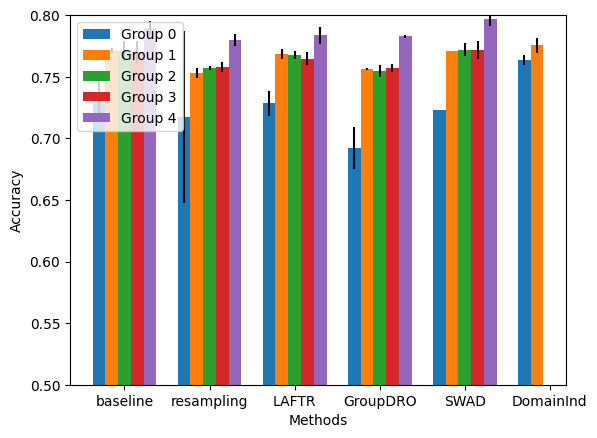

In [ ]:
mean_cols = ['mean Test acc-group_{}'.format(i) for i in range(5)]
sd_cols = ['std Test acc-group_{}'.format(i) for i in range(5)]

# Convert the columns to numeric
numeric_cols = mean_cols + sd_cols
age_results_df[numeric_cols] = age_results_df[numeric_cols].apply(pd.to_numeric)

# Width of the bars
bar_width = 0.15  # Adjust as needed

# Set up positions for the bars
bar_positions = [range(len(age_results_df['methods'])) for _ in range(5)]
bar_positions = [[pos + i * bar_width for pos in bar_positions[0]] for i in range(5)]

# Create bar plots with error bars for each group
for i in range(5):
    plt.bar(bar_positions[i], age_results_df[mean_cols[i]], yerr=age_results_df[sd_cols[i]], width=bar_width, label=f'Group {i}')

# Set labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.ylim((0.5, 0.8))  # Adjust the y-axis limits as needed
plt.xticks([pos + bar_width * 2 for pos in bar_positions[0]], age_results_df['methods'])
plt.legend()

# Show the plot
plt.show()

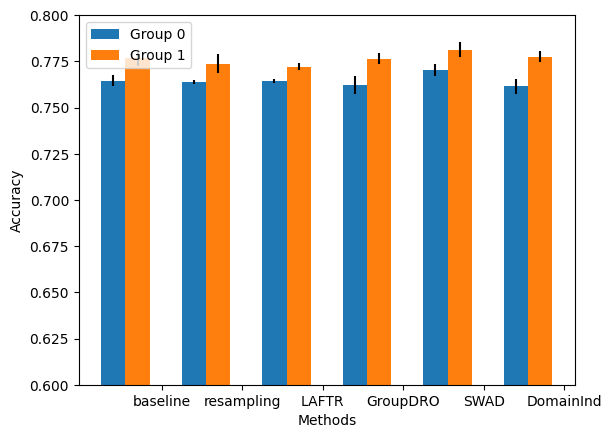

In [ ]:
s = 2 # number of sensitive attributes
df = sex_results_df

mean_cols = ['mean Test acc-group_{}'.format(i) for i in range(s)]
sd_cols = ['std Test acc-group_{}'.format(i) for i in range(s)]

# Convert the columns to numeric
numeric_cols = mean_cols + sd_cols
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Width of the bars
bar_width = 0.3  # Adjust as needed

# Set up positions for the bars
bar_positions = [range(len(df['methods'])) for _ in range(s)]
bar_positions = [[pos + i * bar_width for pos in bar_positions[0]] for i in range(s)]

# Create bar plots with error bars for each group
for i in range(s):
    plt.bar(bar_positions[i], df[mean_cols[i]], yerr=df[sd_cols[i]], width=bar_width, label=f'Group {i}')

# Set labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.ylim((0.6, 0.8))  # Adjust the y-axis limits as needed
plt.xticks([pos + bar_width * 2 for pos in bar_positions[0]], df['methods'])
plt.legend()

# Show the plot
plt.show()

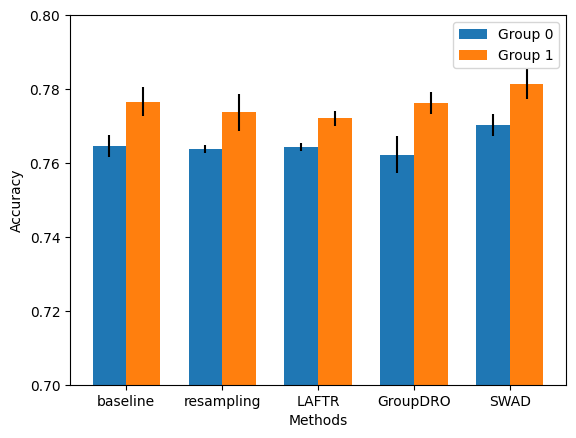

In [ ]:
auc_results_df[['Mean acc-group_0', 'acc-SD-group_0']] = auc_results_df['Test acc-group_0'].str.split('±', expand=True)
auc_results_df[['Mean acc-group_1', 'acc-SD-group_1']] = auc_results_df['Test acc-group_1'].str.split('±', expand=True)

# Convert the columns to numeric
numeric_cols = ['Mean acc-group_0', 'acc-SD-group_0', 'Mean acc-group_1', 'acc-SD-group_1']
auc_results_df[numeric_cols] = auc_results_df[numeric_cols].apply(pd.to_numeric)

# Width of the bars
bar_width = 0.35

# Set up positions for the bars
bar_positions_group_0 = range(len(auc_results_df['methods']))
bar_positions_group_1 = [pos + bar_width for pos in bar_positions_group_0]

# Create bar plots with error bars
plt.bar(bar_positions_group_0, auc_results_df['Mean acc-group_0'], yerr=auc_results_df['acc-SD-group_0'], width=bar_width, label='Group 0')
plt.bar(bar_positions_group_1, auc_results_df['Mean acc-group_1'], yerr=auc_results_df['acc-SD-group_1'], width=bar_width, label='Group 1')

# Set labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.ylim((0.7,0.8))
plt.xticks([pos + bar_width/2 for pos in bar_positions_group_0], auc_results_df['methods'])
plt.legend()

# Show the plot
plt.show()

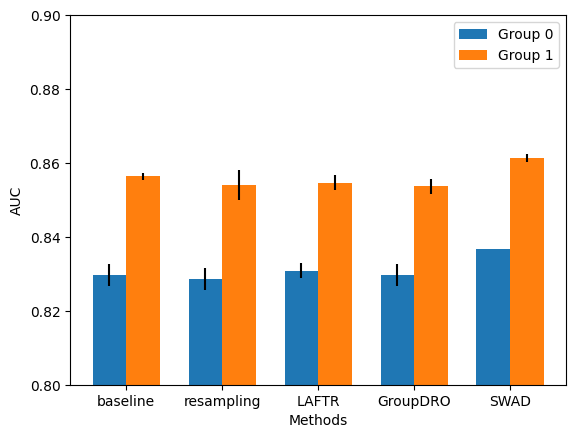

In [ ]:
auc_results_df[['Mean auc-group_0', 'SD-group_0']] = auc_results_df['Test auc-group_0'].str.split('±', expand=True)
auc_results_df[['Mean auc-group_1', 'SD-group_1']] = auc_results_df['Test auc-group_1'].str.split('±', expand=True)

# Convert the columns to numeric
numeric_cols = ['Mean auc-group_0', 'SD-group_0', 'Mean auc-group_1', 'SD-group_1']
auc_results_df[numeric_cols] = auc_results_df[numeric_cols].apply(pd.to_numeric)

# Width of the bars
bar_width = 0.35

# Set up positions for the bars
bar_positions_group_0 = range(len(auc_results_df['methods']))
bar_positions_group_1 = [pos + bar_width for pos in bar_positions_group_0]

# Create bar plots with error bars
plt.bar(bar_positions_group_0, auc_results_df['Mean auc-group_0'], yerr=auc_results_df['SD-group_0'], width=bar_width, label='Group 0')
plt.bar(bar_positions_group_1, auc_results_df['Mean auc-group_1'], yerr=auc_results_df['SD-group_1'], width=bar_width, label='Group 1')

# Set labels and title
plt.xlabel('Methods')
plt.ylabel('AUC')
plt.ylim((0.8,0.9))
plt.xticks([pos + bar_width/2 for pos in bar_positions_group_0], auc_results_df['methods'])
plt.legend()

# Show the plot
plt.show()

### Calculate Max/Min/Gap for Different selections


In [ ]:
def get_max_min_gap(df_ori):
    df = df_ori.copy()
    mean_std = df.drop(columns=['hash']).to_numpy()

    rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
    means = np.zeros(rt.shape)
    
    for i in range(rt.shape[0]):
        for j in range(rt.shape[1]):
            means[i][j] = float(rt[i][j][0])
    means = pd.DataFrame(means, columns = df.columns[1:-1])

    aucs = means[list(means.filter(regex=("auc-group")))]
    aucs = aucs.to_numpy()
    max_auc, min_auc = [], []
    for i in range(aucs.shape[0]):
        temp = aucs[i].tolist()
        max_auc.append(max(temp))
        min_auc.append(min(temp))
    gap = np.asarray(max_auc)-np.asarray(min_auc)
    return np.asarray(max_auc), np.asarray(min_auc), gap

ROOT = '/gpfs3/well/papiez/users/hri611/python/MEDFAIR-PROJECT/MEDFAIR/'
test_results_path = os.path.join(ROOT,'results/selections/')
selections = ['DTO', 'overall_auc'] # 'pareto']
for selection in selections:
    exp_paths = os.listdir(os.path.join(test_results_path, selection))
    for exp_path in exp_paths:
        
        result_path = os.path.join(test_results_path, selection, exp_path)
        results = pd.read_csv(result_path)
        # cal
        max_auc, min_auc, gap = get_max_min_gap(results)
        results['Max AUC'] = max_auc
        results['Min AUC'] = min_auc
        results['AUC Gap'] = gap
    
        results.to_csv(result_path, index = False)

### Calculate EqOdd for non-binary subgroups for completeness

## rank them

In [ ]:
#methods = ['baseline', 'resampling', 'DomainInd', 'LAFTR', 'CFair', 'LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']
methods = ['baseline', 'resampling', 'LAFTR','GroupDRO', 'SWAD']

for selection in selections:
    result_path = os.path.join(ROOT,'results/selections/{}/'.format(selection))
    results = glob.glob(result_path + '*.csv')

    for result in results:
        names = result.split('/')[-1].split('.csv')[0].split('-')
        dataset, sensitive  = names[0], names[1]
        #if dataset != 'RadFusion_EHR':
        #    continue
        
        mean_std_df = pd.read_csv(result).drop(columns=['hash'])
        
        mean_std = mean_std_df.to_numpy()
        
        rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
        means = np.zeros(rt.shape)
        
        for i in range(rt.shape[0]):
            for j in range(rt.shape[1]):
                means[i][j] = float(rt[i][j][0])
        means = pd.DataFrame(means, columns = mean_std_df.columns[1:])
        # todo some ascending, some descending
        means = means.rank(ascending = False, numeric_only = True)
        try:
            means['methods'] = methods
        except:
            means['methods'] = mean_std_df['methods']
        means = means[ ['methods'] + [ col for col in means.columns if col != 'methods' ] ]
    
        means.to_csv(os.path.join(ROOT,'results/selections/{}/{}-{}.csv'.format(selection+'_rank', dataset, sensitive)), index = False)
means

,methods,Test Overall AUC,Test auc-group_0,Test auc-group_1,Test Overall Acc,Test acc-group_0,Test acc-group_1,Test DP,Test EqOpp1,Test EqOpp0,...,Test worst_auc,Test Overall FPR,Test Overall FNR,Test FPR-group_0,Test FPR-group_1,Test FNR-group_0,Test FNR-group_1,Max AUC,Min AUC,AUC Gap
0,baseline,2.0,3.0,2.0,2.0,2.0,2.0,3.0,2.0,3.0,...,3.0,4.0,1.5,4.0,3.0,2.0,2.0,2.0,3.0,1.0
1,resampling,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,5.0,2.0,3.0,2.0,2.0,1.0,4.0,4.0,5.0,2.0
2,LAFTR,3.0,2.0,3.0,5.0,3.0,5.0,5.0,5.0,5.0,...,2.0,1.0,4.0,3.0,1.0,3.0,5.0,3.0,2.0,5.0
3,GroupDRO,4.0,4.0,5.0,3.0,5.0,3.0,1.0,3.0,2.0,...,4.0,3.0,1.5,1.0,4.0,4.0,1.0,5.0,4.0,4.0
4,SWAD,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,...,1.0,5.0,5.0,5.0,5.0,5.0,3.0,1.0,1.0,3.0


## Statistic Test

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import scikit_posthocs as sp
import glob
#import Orange
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
selections = ['overall_auc', 'DTO']
Metrics = ['Min AUC', 'AUC Gap', 'Test Overall AUC']
#methods_toplot = ['ERM', 'Resampling', 'DomainInd', 'LAFTR', 'CFair', 'LNL', 'EnD', 'ODR', 'GroupDRO', 'SWAD', 'SAM']
methods_toplot = ['baseline', 'resampling', 'LAFTR','GroupDRO', 'SWAD']


for metric in Metrics:
    for selection in selections:
        result_path = os.path.join(ROOT,'results/selections/{}/'.format(selection + '_rank'))
        
        results = glob.glob(result_path + '*.csv')
    
        min_ranks, max_ranks, gap_ranks, overall_ranks = [], [], [], []
        ranks = []
        for result in results:
            names = result.split('/')[-1].split('.csv')[0].split('-')
            dataset, sensitive  = names[0], names[1]
            if dataset not in exp_dict.keys():
                continue
            
            mean_std_df = pd.read_csv(result)
            
            values = mean_std_df[metric].values
            if metric == 'AUC Gap':
                values = 12 - values
            ranks.append(values)
    
            avgrank = np.nanmean(ranks, 0)
            
        cd = Orange.evaluation.compute_CD(avgrank, len(ranks), alpha='0.05', test='nemenyi') 
        print('cd=', cd)
        Orange.evaluation.graph_ranks(avgrank, methods_toplot, cd=cd, width=5, textspace=1.5,
                                filename = 'results/selections/cd_diagrams/{}_{}_in_distribution.pdf'.format(selection, metric))

    

### Results of Baseline under different model selections

### rank across datasets

In [ ]:
selections = ['overall_auc', 'DTO', 'pareto']
#Metrics = ['Max AUC', 'Min AUC', 'AUC Gap', 'Test Overall AUC']
Metrics = ['Test Overall AUC']

methods_toplot = ['ERM']
total_df = pd.DataFrame()

for selection in selections:
    
    value_path = './results/selections/{}/'.format(selection)
    value_results = natsorted(glob.glob(value_path + '*.csv'))

    mean_values = []
    column_names = []
    for value_result in value_results:
        dataset, sensitive = value_result.split('/')[-1].split('.csv')[0].split('-')
        column_names.append(dataset  + '-' + sensitive)

        # process values
        value_df = pd.read_csv(value_result).drop(columns=['hash'])
        mean_std = value_df.to_numpy()
        
        rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
        means = np.zeros(rt.shape)
        
        for i in range(rt.shape[0]):
            for j in range(rt.shape[1]):
                means[i][j] = float(rt[i][j][0])
        means = pd.DataFrame(means, columns = value_df.columns[1:])

        values = means[Metrics].iloc[0]
        mean_values.append(values)

    mean_values = np.stack(mean_values).squeeze()
        
    total_df = pd.concat([total_df, pd.DataFrame([mean_values], columns=column_names)])

total_df['Selection Strategy'] = ['Overall Performance', 'DTO', 'Pareto Optimal']
total_df = total_df[ ['Selection Strategy'] + [ col for col in total_df.columns if col != 'Selection Strategy' ] ]
total_df

total_rank_df = total_df.rank(ascending = False, numeric_only = True)
rank_values = total_rank_df.to_numpy()
avgrank = np.mean(rank_values, axis=1)

cd = Orange.evaluation.compute_CD(avgrank, 16, alpha='0.05', test='nemenyi') #tested on 13 datasets 
print('cd=', cd)
Orange.evaluation.graph_ranks(avgrank, total_df['Selection Strategy'].values, cd=cd, width=5, textspace=1.5,
                        filename = 'results/selections/cd_diagrams/{}_{}_in_distribution.pdf'.format(selection, metric))
           

## Plot for ”Bias widely exists“

In [ ]:
selections = ['overall_auc']
#Metrics = ['Max AUC', 'Min AUC', 'AUC Gap', 'Test Overall AUC']
Metrics = ['AUC Gap']

def get_aucs(dataset, sensitive, mode = 'id'):
    
    filename = dataset + '-' + sensitive + '.csv'
    result_path = './results/selections/overall_auc/'
    mean_std_df = pd.read_csv(result_path + filename).drop(columns=['hash'])
    
    mean_std = mean_std_df.to_numpy()

    rt = np.char.split(mean_std[:, 1:].astype('str'), u"\u00B1")
    means = np.zeros(rt.shape)
    
    for i in range(rt.shape[0]):
        for j in range(rt.shape[1]):
            means[i][j] = float(rt[i][j][0])
            #stds[i][j] = float(rt[i][j][1])
    means = pd.DataFrame(means, columns = mean_std_df.columns[1:])

    aucs = means[list(means.filter(regex=("auc-group")))].iloc[0].values.tolist()
    max_auc, min_auc = np.max(aucs), np.min(aucs)

    if dataset in ['MIMIC_CXR', 'CXP']:
        fprs = means[list(means.filter(regex=("FPR-group")))].iloc[0].values.tolist()
        max_under, min_under = np.max(fprs), np.min(fprs)
    else:
        fnrs = means[list(means.filter(regex=("FNR-group")))].iloc[0].values.tolist()
        max_under, min_under = np.max(fnrs), np.min(fnrs)


    return max_auc, min_auc, max_under, min_under #np.asarray(max_auc), , harmonic_mean


total_df = pd.DataFrame()
for selection in selections:
    
    value_path = './results/selections/{}/'.format(selection)
    value_results = natsorted(glob.glob(value_path + '*.csv'))

    maxs, mins, max_unders, min_unders, names = [], [], [], [], []
    for value_result in value_results:
        dataset, sensitive = value_result.split('/')[-1].split('.csv')[0].split('-')
        
        max_auc, min_auc, max_under, min_under = get_aucs(dataset, sensitive)
        
        maxs.append(max_auc)
        mins.append(min_auc)
        max_unders.append(max_under)
        min_unders.append(min_under)
        names.append(dataset+'-'+sensitive)


In [ ]:
names = ['ADNI-Age', 'ADNI-Sex', 'COVID_CT_MD-Age', 'COVID_CT_MD-Sex', 'CheXpert-Age', 'CheXpert-Sex', 'CheXpert-Race', 
'Fitzpatrick17k-skin_type', 'HAM10000-Sex', 'HAM10000-Age', 'MIMIC_CXR-Age', 'MIMIC_CXR-Race', 
'MIMIC_CXR-Sex', 'OCT-Age', 'PAPILA-Age', 'PAPILA-Sex']

In [ ]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

<AxesSubplot:xlabel='Min Underdiagnosis Rate', ylabel='Max Underdiagnosis Rate'>

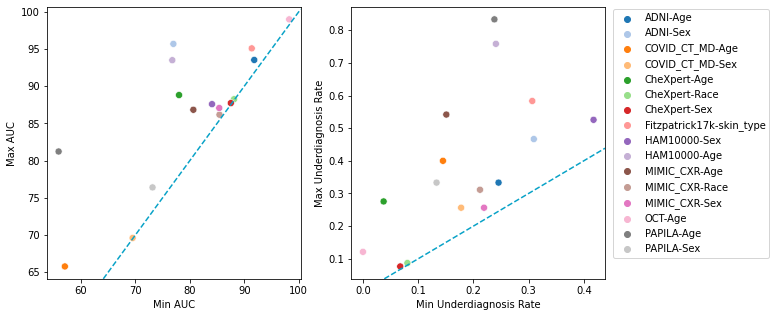

In [ ]:
df = pd.DataFrame([names, maxs, mins], index = ['Datasets', 'Max AUC', 'Min AUC']).T
df2 = pd.DataFrame([names, max_unders, min_unders], index = ['Datasets', 'Max Underdiagnosis Rate', 'Min Underdiagnosis Rate']).T
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
sns.scatterplot(data = df, x = 'Min AUC', y = 'Max AUC', hue = 'Datasets', s = 50, palette = 'tab20', ax = ax)
#ax.legend(bbox_to_anchor=(1.01, 1.05))
ax.get_legend().remove()
add_identity(ax, color="#08a2c7", ls='--')

ax2 = fig.add_subplot(122)
sns.scatterplot(data = df2, x = 'Min Underdiagnosis Rate', y = 'Max Underdiagnosis Rate', hue = 'Datasets', s = 50, palette = 'tab20', ax = ax2)
ax2.legend(bbox_to_anchor=(1.01, 1.01))
add_identity(ax2, color="#08a2c7", ls='--')
plt.savefig('./results/plots/bias_exists.png', dpi = 400, bbox_inches = 'tight')